# Applications of LSTM to the Prediction of Stock Market

Date: Febrary 2023 

## 摘要
XXX


## 准备数据集


第一步是获取股票数据，并将其加载到内存中。我们将从 Yahoo Finance 获取股票数据。Yahoo Finance 是一个丰富的金融市场数据和工具资源，我们可以使用 yfinance 库来从该网站下载股票数据。

In [21]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import yfinance as yf
# For time stamps
from datetime import datetime
import pandas as pd

# as an example, we'll use 'Google' for this analysis
ticker = 'GOOG'

# three years
end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

# download data from Yahoo Finance
stock_data = yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


## 数据分析

In [23]:
# print last 15 records
print(stock_data.tail(15))

                  Open        High         Low       Close   Adj Close    Volume
Date                                                                            
2023-01-30   98.745003   99.408997   97.519997   97.949997   97.949997  24365100
2023-01-31   97.860001   99.910004   97.790001   99.870003   99.870003  22306800
2023-02-01   99.739998  102.190002   98.419998  101.430000  101.430000  26392600
2023-02-02  106.790001  108.820000  106.540001  108.800003  108.800003  46622600
2023-02-03  103.510002  108.019997  103.300003  105.220001  105.220001  36805900
2023-02-06  102.684998  104.699997  102.209999  103.470001  103.470001  25573000
2023-02-07  103.629997  108.669998  103.547997  108.040001  108.040001  33738800
2023-02-08  102.690002  103.580002   98.455002  100.000000  100.000000  73546000
2023-02-09  100.540001  100.610001   93.860001   95.459999   95.459999  97798600
2023-02-10   95.739998   97.019997   94.529999   94.860001   94.860001  49269900
2023-02-13   95.010002   95.


观察打印出来的数据，我们可以发现日期是数据的索引。其他几列的含义如下：
* Open - 当日股票开盘时的价格
* High - 当日股票的最高价格
* Low - 当日股票的最低价格
* Close - 当日收盘时的价格
* Adj Close - 调整后的收盘价
* Volume - 当日股票成交量  

另外，注意到记录中缺少周末的数据，这也符合股市的规则。

### 描述性统计信息

DataFrame 支持使用 describe() 生成描述性统计信息。描述性统计包括汇总数据集分布的中心趋势、分散度和形状的统计，不包括NaN值。

In [24]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02
mean,105.849598,107.140125,104.630873,105.894098,105.894098,3.063571e+07
std,26.097107,26.171685,25.918265,26.027693,26.027693,1.347901e+07
min,52.825500,53.566002,50.676800,52.831001,52.831001,6.936000e+06
25%,86.678625,87.740376,85.880751,86.768623,86.768623,2.185300e+07
50%,104.381248,106.138676,103.523998,104.915001,104.915001,2.724200e+07
75%,129.871372,130.934311,127.521626,129.243504,129.243504,3.512000e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,9.779860e+07


可以发现，过去三年仅有 756 天的股票数据，这是由于周末是没有数据记录的。另外还可以发现，该股票的股价过去一年在[50.676800, 152.100006] 这个区间波动

同样的，我们还可以使用 info() 来获取 DataFrame 的数据信息

In [25]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2020-02-20 to 2023-02-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       756 non-null    float64
 1   High       756 non-null    float64
 2   Low        756 non-null    float64
 3   Close      756 non-null    float64
 4   Adj Close  756 non-null    float64
 5   Volume     756 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.3 KB


### 收盘价


收盘价是股票在正常交易日的最后交易的价格，往往股票的收盘价会被投资者用做跟踪其长期表现的标准基准。因此，我们需要重点关注收盘价(通常关注调整后的收盘价)。

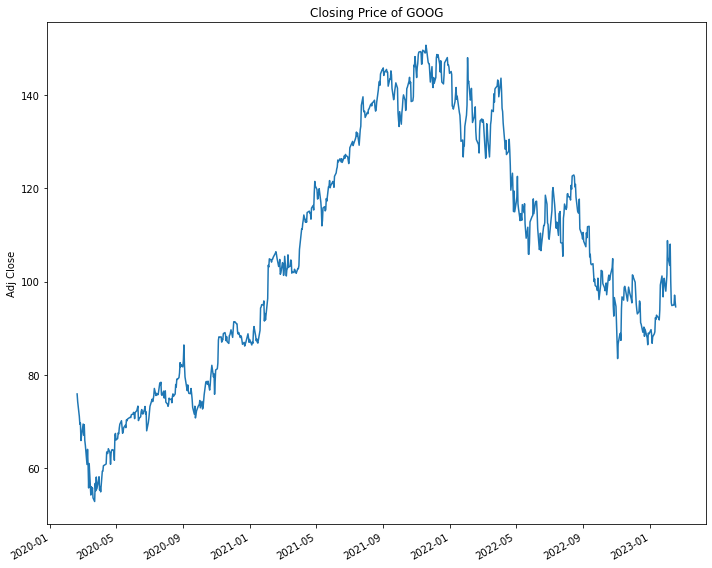

In [50]:
import matplotlib.pyplot as plt

# see a historical view of the closing price
plt.figure(figsize=(10, 8))

stock_data['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of {ticker}")
    
plt.tight_layout()

### 成交量

股票交易量是指每日开盘和收盘之间交易的股票数量。交易量以及交易量随时间的变化是股票技术交易者以及广大股民的重要参考指标。

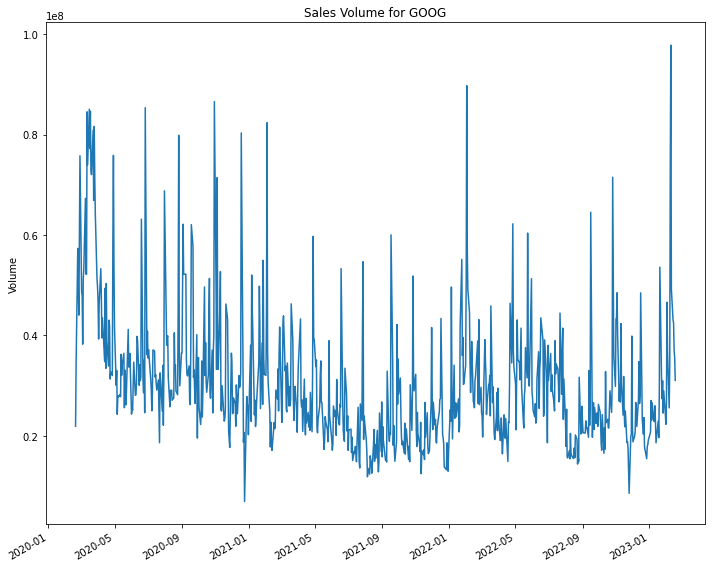

In [49]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(10, 8))

stock_data['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Sales Volume for {ticker}")
    
plt.tight_layout()

可以看出，在2020-05 到 2021-09 期间，谷歌的股价经历了持续不小幅度的上涨。在2022-01 到 2023-01 期间，股票价格持续有所下跌。

### 平均移动线

移动平均线（MA）是一种简单的技术分析工具，通过创建不断更新的平均价格来平滑价格数据。平均值是在特定的时间段内得出的，例如10分钟、20分钟、30分钟或交易者选择的任何时间段。

<Figure size 1440x1080 with 0 Axes>

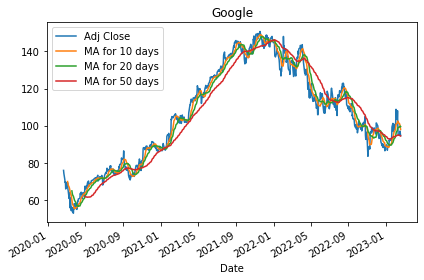

In [53]:
ma_day = [10, 20, 50]

for ma in ma_day:
  column_name = f"MA for {ma} days"
  stock_data[column_name] = stock_data['Adj Close'].rolling(ma).mean()

plt.figure(figsize=(20, 15)) 
stock_data[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title("Google")

plt.tight_layout()

我们在图中看到，测量移动平均值的最佳值是10天和20天，而50天的 MA 和收盘价拟合的效果明显差很多。这是由于10天和20天的MA噪声很少，相对50天而言，仍然是在较少噪声的情况下捕捉数据中的趋势，因此和收盘价高度拟合。

### 每日收益

前面我们已经做了一些基础的数据分析，接下来需要分析购买股票的风险。  
为了做到这一点，我们需要更仔细地观察股票的每日变化，而不仅仅是它的绝对价值。因此，我们关注Google的每日收益

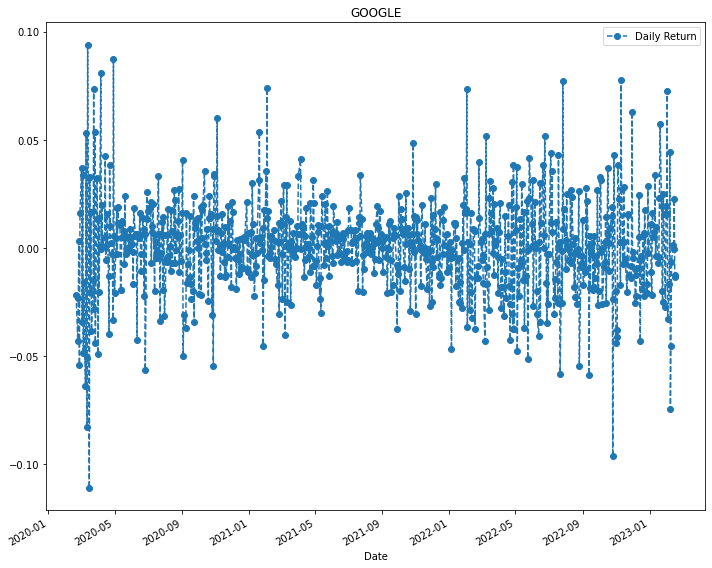

In [52]:
# plot the daily return percentage
plt.figure(figsize=(10, 8)) 

stock_data['Daily Return'] = stock_data['Adj Close'].pct_change()
stock_data['Daily Return'].plot(legend=True, linestyle='--', marker='o')

plt.title('GOOGLE')
plt.tight_layout()

## 模型训练

### CNN

### LSTM